### model.py

In [1]:
import numpy as np
import networkx as nx


# 恒等写像
def identity(x):
    return x

# 入力層
class Input:
    # 入力結合重み行列Winの初期化
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        # 一様分布に従う乱数
        np.random.seed(seed=seed)
        self.Win = np.random.uniform(-input_scale, input_scale, (N_x, N_u))

    # 入力結合重み行列Winによる重みづけ
    def __call__(self, u):
        '''
        param u: N_u次元のベクトル
        return: N_x次元のベクトル
        '''
        return np.dot(self.Win, u)


# リザバー
class Reservoir:
    # リカレント結合重み行列Wの初期化
    def __init__(self, N_x, density, rho, activation_func, leaking_rate,
                 seed=0):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        self.seed = seed
        self.W = self.make_connection(N_x, density, rho)
        self.x = np.zeros(N_x)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.alpha = leaking_rate

    # リカレント結合重み行列の生成
    def make_connection(self, N_x, density, rho):
        # Erdos-Renyiランダムグラフ
        m = int(N_x*(N_x-1)*density/2)  # 総結合数
        G = nx.gnm_random_graph(N_x, m, self.seed)

        # 行列への変換(結合構造のみ）
        connection = nx.to_numpy_matrix(G)
        W = np.array(connection)

        # 非ゼロ要素を一様分布に従う乱数として生成
        rec_scale = 1.0
        np.random.seed(seed=self.seed)
        W *= np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

        # スペクトル半径の計算
        eigv_list = np.linalg.eig(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # 指定のスペクトル半径rhoに合わせてスケーリング
        W *= rho / sp_radius

        return W

    # リザバー状態ベクトルの更新
    def __call__(self, x_in):
        '''
        param x_in: 更新前の状態ベクトル
        return: 更新後の状態ベクトル
        '''
        #self.x = self.x.reshape(-1, 1)
        self.x = (1.0 - self.alpha) * self.x \
                 + self.alpha * self.activation_func(np.dot(self.W, self.x) \
                 + x_in)
        return self.x

    # リザバー状態ベクトルの初期化
    def reset_reservoir_state(self):
        self.x *= 0.0


# 出力層
class Output:
    # 出力結合重み行列の初期化
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        # 正規分布に従う乱数
        np.random.seed(seed=seed)
        self.Wout = np.random.normal(size=(N_y, N_x))

    # 出力結合重み行列による重みづけ
    def __call__(self, x):
        '''
        param x: N_x次元のベクトル
        return: N_y次元のベクトル
        '''
        return np.dot(self.Wout, x)

    # 学習済みの出力結合重み行列を設定
    def setweight(self, Wout_opt):
        self.Wout = Wout_opt


# 出力フィードバック
class Feedback:
    # フィードバック結合重み行列の初期化
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数
        np.random.seed(seed=seed)
        self.Wfb = np.random.uniform(-fb_scale, fb_scale, (N_x, N_y))

    # フィードバック結合重み行列による重みづけ
    def __call__(self, y):
        '''
        param y: N_y次元のベクトル
        return: N_x次元のベクトル
        '''
        return np.dot(self.Wfb, y)

# リッジ回帰（beta=0のときは線形回帰）
class Tikhonov:
    def __init__(self, N_x, N_y, beta):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param beta: 正則化パラメータ
        '''
        self.beta = beta
        self.X_XT = np.zeros((N_x, N_x))
        self.D_XT = np.zeros((N_y, N_x))
        self.N_x = N_x

    # 学習用の行列の更新
    def __call__(self, d, x):
        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        self.X_XT += np.dot(x, x.T)
        self.D_XT += np.dot(d, x.T)

    # Woutの最適解（近似解）の導出
    def get_Wout_opt(self):
        X_pseudo_inv = np.linalg.inv(self.X_XT \
                                     + self.beta*np.identity(self.N_x))
        Wout_opt = np.dot(self.D_XT, X_pseudo_inv)
        return Wout_opt

In [2]:
# エコーステートネットワーク
class ESN:
    # 各層の初期化
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0,
                 rho=0.95, activation_func=np.tanh, fb_scale = None,
                 fb_seed=0, noise_level = None, leaking_rate=1.0,
                 output_func=identity, inv_output_func=identity,
                 classification = False, average_window = None):
        '''
        param N_u: 入力次元
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param density: リザバーのネットワーク結合密度
        param input_scale: 入力スケーリング
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: リザバーノードの活性化関数
        param fb_scale: フィードバックスケーリング（default: None）
        param fb_seed: フィードバック結合重み行列生成に使う乱数の種
        param leaking_rate: leaky integratorモデルのリーク率
        param output_func: 出力層の非線形関数（default: 恒等写像）
        param inv_output_func: output_funcの逆関数
        param classification: 分類問題の場合はTrue（default: False）
        param average_window: 分類問題で出力平均する窓幅（default: None）
        '''
        self.Input = Input(N_u, N_x, input_scale)
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, 
                                   leaking_rate)
        self.Output = Output(N_x, N_y)
        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.y_prev = np.zeros(N_y)
        self.output_func = output_func
        self.inv_output_func = inv_output_func
        self.classification = classification

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新おけるノイズの有無
        if noise_level is None:
            self.noise = None
        else:
            np.random.seed(seed=0)
            self.noise = np.random.uniform(-noise_level, noise_level, 
                                           (self.N_x, 1))

        # 分類問題か否か
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = np.zeros((average_window, N_x))

    # バッチ学習
    def train(self, U, D, optimizer, trans_len = None):
        '''
        U: 教師データの入力, データ長×N_u
        D: 教師データの出力, データ長×N_y
        optimizer: 学習器
        trans_len: 過渡期の長さ
        return: 学習前のモデル出力, データ長×N_y
        '''
        train_len = len(U)
        if trans_len is None:
            trans_len = 0
        Y = []

        # 時間発展
        for n in range(train_len):
            x_in = self.Input(U[n])

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # ノイズ
            if self.noise is not None:
                x_in += self.noise

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 分類問題の場合は窓幅分の平均を取得
            if self.classification:
                self.window = np.append(self.window, x.reshape(1, -1),
                                        axis=0)
                self.window = np.delete(self.window, 0, 0)
                x = np.average(self.window, axis=0)

            # 目標値
            d = D[n]
            d = self.inv_output_func(d)

            # 学習器
            if n > trans_len:  # 過渡期を過ぎたら
                optimizer(d, x)

            # 学習前のモデル出力
            y = self.Output(x)
            Y.append(self.output_func(y))
            self.y_prev = d

        # 学習済みの出力結合重み行列を設定
        self.Output.setweight(optimizer.get_Wout_opt())

        # モデル出力（学習前）
        return np.array(Y)

    # バッチ学習後の予測
    def predict(self, U):
        test_len = len(U)
        Y_pred = []

        # 時間発展
        for n in range(test_len):
            x_in = self.Input(U[n])

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 分類問題の場合は窓幅分の平均を取得
            if self.classification:
                self.window = np.append(self.window, x.reshape(1, -1),
                                        axis=0)
                self.window = np.delete(self.window, 0, 0)
                x = np.average(self.window, axis=0)

            # 学習後のモデル出力
            y_pred = self.Output(x)
            Y_pred.append(self.output_func(y_pred))
            self.y_prev = y_pred

        # モデル出力（学習後）
        return np.array(Y_pred)

    # バッチ学習後の予測（自律系のフリーラン）
    def run(self, U):
        test_len = len(U)
        Y_pred = []
        y = U[0]

        # 時間発展
        for n in range(test_len):
            x_in = self.Input(y)

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 学習後のモデル出力
            y_pred = self.Output(x)
            Y_pred.append(self.output_func(y_pred))
            y = y_pred
            self.y_prev = y

        return np.array(Y_pred)

    # オンライン学習と予測
    def adapt(self, U, D, optimizer):
        data_len = len(U)
        Y_pred = []
        Wout_abs_mean = []

        # 出力結合重み更新
        for n in np.arange(0, data_len, 1):
            x_in = self.Input(U[n])
            x = self.Reservoir(x_in)
            d = D[n]
            d = self.inv_output_func(d)
            
            # 学習
            Wout = optimizer(d, x)

            # モデル出力
            y = np.dot(Wout, x)
            Y_pred.append(y)
            Wout_abs_mean.append(np.mean(np.abs(Wout)))

        return np.array(Y_pred), np.array(Wout_abs_mean)

### spoken_digit_recognition

In [27]:
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sn
import pandas as pd
from scipy.io import loadmat

from sklearn.metrics import confusion_matrix


np.random.seed(seed=0)

# 音声信号を前処理したデータ(コクリアグラム)の読み込み
def read_speech_data(dir_name, utterance_train_list):
    ''' 
    :入力：データファイル(.mat)の入っているディレクトリ名(dir_name)
    :出力：入力データ(input_data)と教師データ(teacher_data)
    '''
    # .matファイルのみを取得
    data_files = glob.glob(os.path.join(dir_name, '*.mat'))

    # データに関する情報
    n_channel = 77  # チャネル数
    n_label = 10  # ラベル数(digitの数)

    # 初期化
    train_input = np.empty((0, n_channel))  # 教師入力
    train_output = np.empty((0, n_label))  # 教師出力
    train_length = np.empty(0, np.int)  # データ長
    train_label = np.empty(0, np.int)  # 正解ラベル
    test_input = np.empty((0, n_channel))  # 教師入力
    test_output = np.empty((0, n_label))  # 教師出力
    test_length = np.empty(0, np.int)  # データ長
    test_label = np.empty(0, np.int)  # 正解ラベル
    
    # データ読み込み
    if len(data_files) > 0:
        print("%d files in %s を読み込んでいます..." \
              % (len(data_files), dir_name))
        for each_file in data_files:
            data = loadmat(each_file)
            utterance = int(each_file[-8])  # 各speakerの発話番号
            digit = int(each_file[-5]) # 発話された数字
            if utterance in utterance_train_list:  # 訓練用
                # 入力データ（構造体'spec'に格納されている）
                train_input = np.vstack((train_input, data['spec'].T))
                # 出力データ（n_tau x 10，値はすべて'-1'）
                tmp = -np.ones([data['spec'].shape[1], 10])
                tmp[:, digit] = 1  # digitの列のみ1
                train_output = np.vstack((train_output, tmp))
                # データ長
                train_length = np.hstack((train_length, data['spec'].shape[1]))
                # 正解ラベル
                train_label = np.hstack((train_label, digit))
            else:  # 検証用
                # 入力データ（構造体'spec'に格納されている）
                test_input = np.vstack((test_input, data['spec'].T))
                # 出力データ（n_tau x 10，値はすべて'-1'）
                tmp = -np.ones([data['spec'].shape[1], 10])
                tmp[:, digit] = 1  # digitの列のみ1
                test_output = np.vstack((test_output, tmp))
                # データ長
                test_length = np.hstack((test_length, data['spec'].shape[1]))
                # 正解ラベル
                test_label = np.hstack((test_label, digit))
    else:
        print("ディレクトリ %s にファイルが見つかりません．" % (indir))
        return
    return train_input, train_output, train_length, train_label, \
           test_input, test_output, test_length, test_label

500 files in ./Lyon_decimation_128 を読み込んでいます...
データ読み込み完了．訓練と検証を行っています...


リザバーの大きさ: 20
訓練誤差： WER = 0.4160
検証誤差： WER = 0.4160
リザバーの大きさ: 40
訓練誤差： WER = 0.1480
検証誤差： WER = 0.1880
リザバーの大きさ: 60
訓練誤差： WER = 0.0960
検証誤差： WER = 0.1360
リザバーの大きさ: 80
訓練誤差： WER = 0.0600
検証誤差： WER = 0.0760
リザバーの大きさ: 100
訓練誤差： WER = 0.0200
検証誤差： WER = 0.0880
リザバーの大きさ: 120
訓練誤差： WER = 0.0120
検証誤差： WER = 0.0440
リザバーの大きさ: 140
訓練誤差： WER = 0.0080
検証誤差： WER = 0.0320
リザバーの大きさ: 160
訓練誤差： WER = 0.0040
検証誤差： WER = 0.0280
リザバーの大きさ: 180
訓練誤差： WER = 0.0080
検証誤差： WER = 0.0200
リザバーの大きさ: 200
訓練誤差： WER = 0.0040
検証誤差： WER = 0.0160


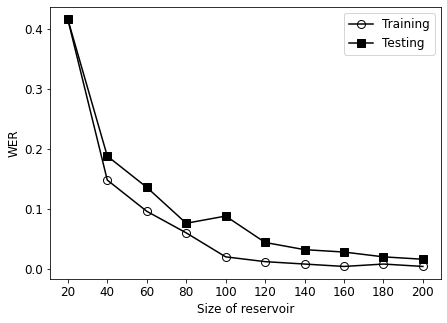

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.io import loadmat
from tqdm.notebook import tqdm

# 訓練データ，検証データの取得
train_list = [1, 2, 3, 4, 5]  # u1-u5が訓練用，残りが検証用
train_input, train_output, train_length, train_label, test_input, \
test_output, test_length, test_label = \
read_speech_data(dir_name='./Lyon_decimation_128',
                  utterance_train_list=train_list)
print("データ読み込み完了．訓練と検証を行っています...")

N_x_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
train_WER = np.empty(0)
test_WER = np.empty(0)
bar = tqdm(total = np.sum(N_x_list))

for N_x in N_x_list:
    print("リザバーの大きさ: %d" % N_x)
    bar.update(N_x)
    
    # ESNモデル
    model = ESN(train_input.shape[1], train_output.shape[1], N_x,
                density=0.05, input_scale=1.0e+4, rho=0.9, fb_scale=0.0)

    ########## 訓練データに対して
    # リザバー状態行列
    stateCollectMat = np.empty((0, N_x))
    for i in range(len(train_input)):
        u_in = model.Input(train_input[i])
        r_out = model.Reservoir(u_in)
        stateCollectMat = np.vstack((stateCollectMat, r_out))

    # 教師出力データ行列
    teachCollectMat = train_output

    # 学習（疑似逆行列）
    Wout = np.dot(teachCollectMat.T, np.linalg.pinv(stateCollectMat.T))

    # ラベル出力
    Y_pred = np.dot(Wout, stateCollectMat.T)
    pred_train = np.empty(0, np.int)
    start = 0
    for i in range(len(train_length)):
        tmp = Y_pred[:,start:start+train_length[i]]  # 1つのデータに対する出力
        max_index = np.argmax(tmp, axis=0)  # 最大出力を与える出力ノード番号
        histogram = np.bincount(max_index)  # 出力ノード番号のヒストグラム
        pred_train = np.hstack((pred_train, np.argmax(histogram)))  # 最頻値
        start = start + train_length[i]

    # 訓練誤差(Word Error Rate, WER)
    count = 0
    for i in range(len(train_length)):
        if pred_train[i] != train_label[i]:
            count = count + 1 
    print("訓練誤差： WER = %5.4lf" % (count/len(train_length)))
    train_WER = np.hstack((train_WER, count/len(train_length)))

    ########## 検証データに対して
    # リザバー状態行列
    stateCollectMat = np.empty((0, N_x))
    for i in range(len(test_input)):
        u_in = model.Input(test_input[i])
        r_out = model.Reservoir(u_in)
        stateCollectMat = np.vstack((stateCollectMat, r_out))

    # ラベル出力
    Y_pred = np.dot(Wout, stateCollectMat.T)
    pred_test = np.empty(0, np.int)
    start = 0
    for i in range(len(test_length)):
        tmp = Y_pred[:,start:start+test_length[i]]  # 1つのデータに対する出力
        max_index = np.argmax(tmp, axis=0)  # 最大出力を与える出力ノード番号
        histogram = np.bincount(max_index)  # 出力ノード番号のヒストグラム
        pred_test = np.hstack((pred_test, np.argmax(histogram)))  # 最頻値
        start = start + test_length[i]
    
    # 検証誤差(WER)
    count = 0
    for i in range(len(test_length)):
        if pred_test[i] != test_label[i]:
            count = count + 1 
    print("検証誤差： WER = %5.4lf" % (count/len(test_length)))
    test_WER = np.hstack((test_WER, count/len(test_length)))

# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(7, 5))

plt.plot(N_x_list, train_WER, marker='o', fillstyle='none',
          markersize=8, color='k', label='Training')         
plt.plot(N_x_list, test_WER, marker='s', 
          markersize=8, color='k', label='Testing')
plt.xticks(N_x_list)
plt.xlabel("Size of reservoir")
plt.ylabel("WER")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.show()

500 files in ./Lyon_decimation_128 を読み込んでいます...
データ読み込み完了．訓練と検証を行っています...
リザバーの大きさ: 100
訓練誤差： WER = 0.0200
検証誤差： WER = 0.0880


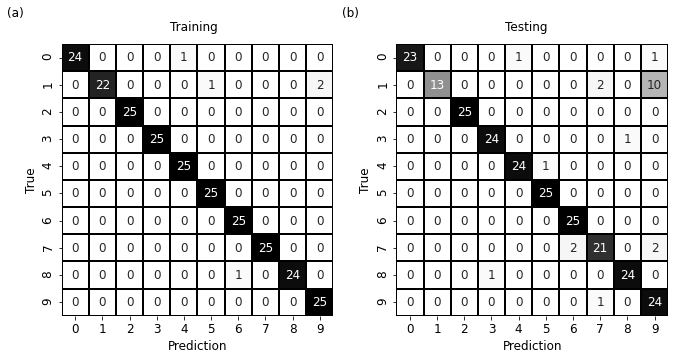

In [28]:
# 訓練データ，検証データの取得
n_label = 10  # ラベル数
train_list = [1, 2, 3, 4, 5]  # u1-u5が訓練用，残りが検証用
train_input, train_output, train_length, train_label, test_input, \
test_output, test_length, test_label = \
read_speech_data(dir_name='./Lyon_decimation_128',
                  utterance_train_list=train_list)
print("データ読み込み完了．訓練と検証を行っています...")

N_x = 100  # リザバーの大きさ
print("リザバーの大きさ: %d" % N_x)
train_WER = np.empty(0)
test_WER = np.empty(0)

# ESNモデル
model = ESN(train_input.shape[1], train_output.shape[1], N_x,
            density=0.05, input_scale=1.0e+4, rho=0.9, fb_scale=0.0)

########## 訓練データに対して
# リザバー状態行列
stateCollectMat = np.empty((0, N_x))
for i in range(len(train_input)):
    u_in = model.Input(train_input[i])
    r_out = model.Reservoir(u_in)
    stateCollectMat = np.vstack((stateCollectMat, r_out))

# 教師出力データ行列
teachCollectMat = train_output

# 学習（疑似逆行列）
Wout = np.dot(teachCollectMat.T, np.linalg.pinv(stateCollectMat.T))

# ラベル出力
Y_pred = np.dot(Wout, stateCollectMat.T)
pred_train = np.empty(0, np.int)
start = 0
for i in range(len(train_length)):
    tmp = Y_pred[:,start:start+train_length[i]]  # 1つのデータに対する出力
    max_index = np.argmax(tmp, axis=0)  # 最大出力を与える出力ノード番号
    histogram = np.bincount(max_index)  # 出力ノード番号のヒストグラム
    pred_train = np.hstack((pred_train, np.argmax(histogram)))  # 最頻値 
    start = start + train_length[i]

# 訓練誤差(Word Error Rate, WER)
count = 0
for i in range(len(train_length)):
    if pred_train[i] != train_label[i]:
        count = count + 1 
print("訓練誤差： WER = %5.4lf" % (count/len(train_length)))
train_WER = np.hstack((train_WER, count/len(train_length)))

# 混同行列
cm_train = confusion_matrix(train_label, pred_train, range(n_label))
    
########## 検証データに対して
# リザバー状態行列
stateCollectMat = np.empty((0, N_x))
for i in range(len(test_input)):
    u_in = model.Input(test_input[i])
    r_out = model.Reservoir(u_in)
    stateCollectMat = np.vstack((stateCollectMat, r_out))

# ラベル出力
Y_pred = np.dot(Wout, stateCollectMat.T)
pred_test = np.empty(0, np.int)
start = 0
for i in range(len(test_length)):
    tmp = Y_pred[:,start:start+test_length[i]]  # 1つのデータに対する出力
    max_index = np.argmax(tmp, axis=0)  # 最大出力を与える出力ノード番号
    histogram = np.bincount(max_index)  # 出力ノード番号のヒストグラム
    pred_test = np.hstack((pred_test, np.argmax(histogram)))  # 最頻値
    start = start + test_length[i]
    
# 検証誤差(WER)
count = 0
for i in range(len(test_length)):
    if pred_test[i] != test_label[i]:
        count = count + 1 
print("検証誤差： WER = %5.4lf" % (count/len(test_length)))
test_WER = np.hstack((test_WER, count/len(test_length)))

# 混同行列
cm_test = confusion_matrix(test_label, pred_test, range(n_label))
    
# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(11, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.text(-0.2, 1.1, '(a)', transform=ax1.transAxes)
ax1.text(0.4, 1.05, 'Training', transform=ax1.transAxes)
df_cm_train = pd.DataFrame(cm_train, range(n_label), range(n_label))
sn.heatmap(df_cm_train, cmap='Greys', annot=True, linewidths=1,
            linecolor='black', cbar=False, square=True, ax=ax1)
plt.xlabel('Prediction')
plt.ylabel('True')

ax2 = fig.add_subplot(1, 2, 2)
ax2.text(-0.2, 1.1, '(b)', transform=ax2.transAxes)
ax2.text(0.4, 1.05, 'Testing', transform=ax2.transAxes)
df_cm_test = pd.DataFrame(cm_test, range(n_label), range(n_label))
sn.heatmap(df_cm_test, cmap='Greys', annot=True, linewidths=1,
            linecolor='black', cbar=False, square=True, ax=ax2)
plt.xlabel('Prediction')
plt.ylabel('True')

plt.show()

### anomaly_detection_ECG

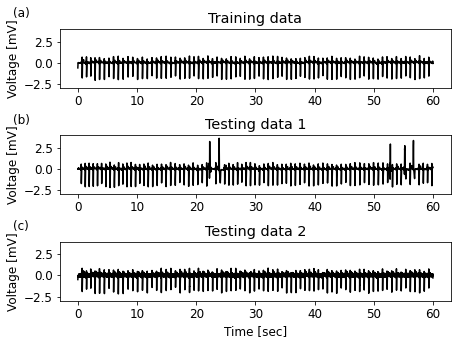

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 心電図波形(ECG)データの読み込み
def read_ecg_data(file_name):
    ''' 
    :入力：データファイル名, file_name
    :出力：ECGデータ, data
    '''
    data = np.empty(0)
    count = 0
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            if count >= 2:  # ヘッダ削除
                data = np.hstack((data, float(tmp[1])))  # ECG1[mV]
            count = count + 1
    return data
    

# 訓練データ、検証データ
normal = read_ecg_data(file_name='./normal.txt')
anomaly = read_ecg_data(file_name='./anomaly.txt')
normal_noise = read_ecg_data(file_name='./normal.txt')
normal_noise = normal_noise + \
    0.4 * (np.random.rand(normal_noise.shape[0]) - 0.5)

# 時間
t = np.linspace(0, 60, 7680)

# グラフ表示
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.8)

ax1 = fig.add_subplot(3, 1, 1)
ax1.text(-0.12, 1.2, '(a)', transform=ax1.transAxes)
plt.plot(t, normal, color='k')
plt.ylim([-3, 4])
plt.title("Training data")
plt.ylabel("Voltage [mV]")

ax2 = fig.add_subplot(3, 1, 2)
ax2.text(-0.12, 1.2, '(b)', transform=ax2.transAxes)
plt.plot(t, anomaly, color='k')
plt.ylim([-3, 4])
plt.title("Testing data 1")
plt.ylabel("Voltage [mV]")

ax3 = fig.add_subplot(3, 1, 3)
ax3.text(-0.12, 1.2, '(c)', transform=ax3.transAxes)
plt.plot(t, normal_noise, color='k')
plt.ylim([-3, 4])
plt.title("Testing data 2")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [sec]")

plt.show()

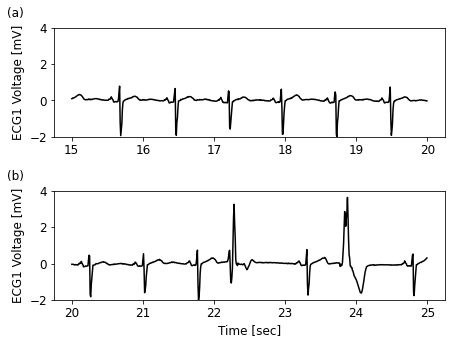

In [34]:
# 訓練データ、検証データ
normal = read_ecg_data(file_name='./normal.txt')
anomaly = read_ecg_data(file_name='./anomaly.txt')

# 時間
t = np.linspace(0, 60, 7680)

# グラフ表示
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(2, 1, 1)
ax1.text(-0.12, 1.1, '(a)', transform=ax1.transAxes)
plt.plot(t[15*128:20*128], anomaly[15*128:20*128], color='k')
plt.ylim([-2,4])
plt.ylabel("ECG1 Voltage [mV]")

ax2 = fig.add_subplot(2, 1, 2)
ax2.text(-0.12, 1.1, '(b)', transform=ax2.transAxes)
plt.plot(t[20*128:25*128], anomaly[20*128:25*128], color='k')
plt.ylim([-2,4])
plt.xlabel("Time [sec]")
plt.ylabel("ECG1 Voltage [mV]")

plt.show()

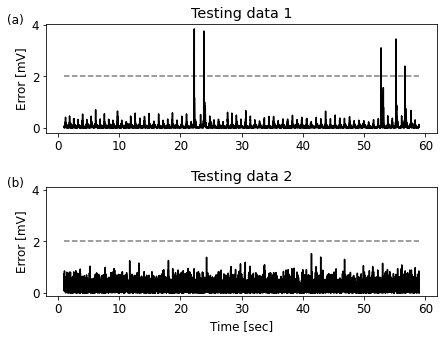

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# ECGデータ
normal = read_ecg_data(file_name='./normal.txt')
anomaly = read_ecg_data(file_name='./anomaly.txt')
normal_noise = read_ecg_data(file_name='./normal.txt')
normal_noise = normal_noise + 0.4 * (np.random.rand(normal_noise.shape[0]) - 0.5)

# 訓練、検証データ
unit_sample = 128  # 1secあたりのサンプル数
T_start = 1*unit_sample
T_end = 59*unit_sample

train_X = normal[T_start:T_end].reshape(-1, 1)
train_Y = normal[T_start+1:T_end+1].reshape(-1, 1)

test_X = anomaly[T_start:T_end].reshape(-1, 1)
test_Y = anomaly[T_start+1:T_end+1].reshape(-1, 1)

test2_X = normal_noise[T_start:T_end].reshape(-1, 1)
test2_Y = normal_noise[T_start+1:T_end+1].reshape(-1, 1)

# ESNモデルの設定
N_x = 100  # リザバーの大きさ
model = ESN(train_X.shape[1], train_Y.shape[1], N_x,
            density=0.1, input_scale=1, rho=0.8)

# 学習
train_Y_pred = model.train(train_X, train_Y,
                            Tikhonov(N_x, train_Y.shape[1], 1e-2))

# 検証データに対する予測と誤差
test_Y_pred = model.predict(test_X)
error = abs(test_Y_pred - test_Y)
test_Y_pred = model.predict(test2_X)
error2 = abs(test_Y_pred - test2_Y)

# グラフ表示
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.5)

t = np.linspace(1, 59, error.shape[0])  # 時間（秒）
threshold = 2  # 閾値

ax1 = fig.add_subplot(2, 1, 1)
ax1.text(-0.1, 1, '(a)', transform=ax1.transAxes)
plt.plot(t, error, color='k')
plt.ylabel("Error [mV]")
#plt.yscale('log')
plt.hlines([threshold], 1, 59, "gray", linestyles='dashed') 
plt.title("Testing data 1")

ax2 = fig.add_subplot(2, 1, 2)
ax2.text(-0.1, 1, '(b)', transform=ax2.transAxes)
plt.plot(t, error2, color='k')
plt.xlabel("Time [sec]")
plt.ylabel("Error [mV]")
#plt.yscale('log')
plt.ylim([-0.1, 4.1])
plt.hlines([threshold], 1, 59, "gray", linestyles='dashed') 
plt.title("Testing data 2")

plt.show()

### prediction_sunspot

1 ステップ先予測
訓練誤差：NRMSE = 0.06975749720624054
1 ステップ先予測
検証誤差：NRMSE = 0.0284344565922479
10 ステップ先予測
訓練誤差：NRMSE = 0.4869701319478197
10 ステップ先予測
検証誤差：NRMSE = 0.29711355736499595


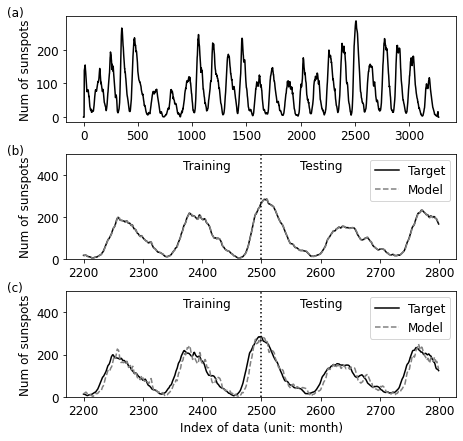

In [5]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(seed=0)

# データの読み込み
def read_sunspot_data(file_name):
    ''' 
    :入力：データファイル名, file_name
    :出力：黒点数データ, data
    '''
    data = np.empty(0)
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            data = np.hstack((data, float(tmp[3])))  # 3rd column
    return data

    
# 黒点数データ
sunspots = read_sunspot_data(file_name='SN_ms_tot_V2.0.txt')

# データのスケーリング
data_scale = 1.0e-3
data = sunspots*data_scale

# 複数ステップ先の予測
step_list = [1,10]
for step in step_list:
    
    # 訓練・検証データ長
    T_train = 2500
    T_test = data.size-T_train-step

    # 訓練・検証用情報
    train_U = data[:T_train].reshape(-1, 1)
    train_D = data[step:T_train+step].reshape(-1, 1)
    
    test_U = data[T_train:T_train+T_test].reshape(-1, 1)
    test_D = data[T_train+step:T_train+T_test+step].reshape(-1, 1)
    
    # ESNモデル
    N_x = 300  # リザバーのノード数
    model = ESN(train_U.shape[1], train_D.shape[1], N_x, density=0.1, input_scale=0.1, rho=0.9)
    
    # 学習(リッジ回帰)
    train_Y = model.train(train_U, train_D, Tikhonov(N_x, train_D.shape[1], 1e-3))
    
    # モデル出力
    train_Y = model.predict(train_U)
    test_Y = model.predict(test_U)
    
    # 訓練誤差評価（NRMSE）
    RMSE = np.sqrt(((train_D/data_scale - train_Y/data_scale) ** 2)
                          .mean())
    NRMSE = RMSE/np.sqrt(np.var(train_D/data_scale))
    print(step, 'ステップ先予測')
    print('訓練誤差：NRMSE =', NRMSE)

    # 検証誤差評価（NRMSE）
    RMSE = np.sqrt(((test_D/data_scale - test_Y/data_scale) ** 2)
                        .mean())
    NRMSE = RMSE/np.sqrt(np.var(test_D/data_scale))
    print(step, 'ステップ先予測')
    print('検証誤差：NRMSE =', NRMSE)

    # step=1,10の場合を記録
    if step==1:
        # グラフ表示用データ
        T_disp = (T_train-300, T_train+300)
        t_axis = np.arange(T_disp[0], T_disp[1], 1)
        disp_D_step1 = np.concatenate((train_D[T_disp[0]-T_train:], 
                                      test_D[:T_disp[1]-T_train]))
        disp_Y_step1 = np.concatenate((train_Y[T_disp[0]-T_train:], 
                                      test_Y[:T_disp[1]-T_train]))
    else:
        # グラフ表示用データ
        T_disp = (T_train-300, T_train+300)
        t_axis = np.arange(T_disp[0], T_disp[1], 1)
        disp_D_step10 = np.concatenate((train_D[T_disp[0]-T_train:], 
                                        test_D[:T_disp[1]-T_train]))
        disp_Y_step10 = np.concatenate((train_Y[T_disp[0]-T_train:], 
                                        test_Y[:T_disp[1]-T_train]))
    
# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(7, 7))
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(3, 1, 1)
ax1.text(-0.15, 1, '(a)', transform=ax1.transAxes)
plt.plot(data/data_scale, color='k')
plt.ylabel('Num of sunspots')

ax2 = fig.add_subplot(3, 1, 2)
ax2.text(-0.15, 1, '(b)', transform=ax2.transAxes)
ax2.text(0.3, 0.85, 'Training', transform=ax2.transAxes)
ax2.text(0.6, 0.85, 'Testing', transform=ax2.transAxes)
plt.plot(t_axis, disp_D_step1[:,0]/data_scale, color='k', label='Target')
plt.plot(t_axis, disp_Y_step1[:,0]/data_scale, color='gray',
          linestyle='--', label='Model')
plt.ylabel('Num of sunspots')
plt.ylim([0,500])
plt.axvline(x=T_train, ymin=0, ymax=1, color='k', linestyle=':')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')

ax3 = fig.add_subplot(3, 1, 3)
ax3.text(-0.15, 1, '(c)', transform=ax3.transAxes)
ax3.text(0.3, 0.85, 'Training', transform=ax3.transAxes)
ax3.text(0.6, 0.85, 'Testing', transform=ax3.transAxes)
plt.plot(t_axis, disp_D_step10[:,0]/data_scale, color='k', label='Target')
plt.plot(t_axis, disp_Y_step10[:,0]/data_scale, color='gray',
          linestyle='--', label='Model')
plt.xlabel('Index of data (unit: month)')
plt.ylabel('Num of sunspots')
plt.ylim([0,500])
plt.axvline(x=T_train, ymin=0, ymax=1, color='k', linestyle=':')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.show()

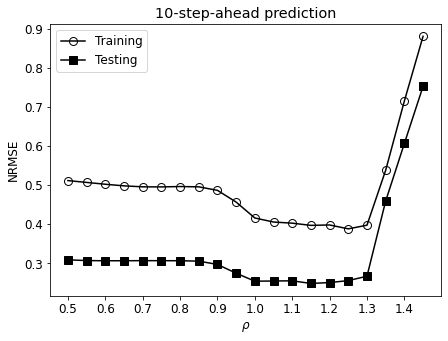

In [6]:
# 黒点数データ
sunspots = read_sunspot_data(file_name='SN_ms_tot_V2.0.txt')

# データのスケーリング
data_scale = 1.0e-3
data = sunspots*data_scale

# 複数ステップ先の予測
step = 10

# スペクトル半径rhoを変化させる
rho_list = np.arange(0.5,1.5,0.05)
train_NRMSE = np.empty(0)
test_NRMSE = np.empty(0)
for rho in rho_list:
    
    # 訓練・検証データ長
    T_train = 2500
    T_test = data.size-T_train-step

    # 訓練・検証用情報
    train_U = data[:T_train].reshape(-1, 1)
    train_D = data[step:T_train+step].reshape(-1, 1)
    
    test_U = data[T_train:T_train+T_test].reshape(-1, 1)
    test_D = data[T_train+step:T_train+T_test+step].reshape(-1, 1)
    
    # ESNモデル
    N_x = 300  # リザバーのノード数
    model = ESN(train_U.shape[1], train_D.shape[1], N_x, density=0.1, 
                input_scale=0.1, rho=rho)
    
    # 学習(リッジ回帰)
    train_Y = model.train(train_U, train_D, 
                          Tikhonov(N_x, train_D.shape[1], 1e-3))
    
    # モデル出力
    train_Y = model.predict(train_U)
    test_Y = model.predict(test_U)
    
    # 訓練誤差評価（NRMSE）
    RMSE = np.sqrt(((train_D/data_scale - train_Y/data_scale) ** 2)
                    .mean())
    NRMSE = RMSE/np.sqrt(np.var(train_D/data_scale))
    train_NRMSE = np.hstack((train_NRMSE, NRMSE))
    
    # 検証誤差評価（NRMSE）
    RMSE = np.sqrt(((test_D/data_scale - test_Y/data_scale) ** 2)
                    .mean())
    NRMSE = RMSE/np.sqrt(np.var(test_D/data_scale))
    test_NRMSE = np.hstack((test_NRMSE, NRMSE))

# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(7, 5))

plt.plot(rho_list, train_NRMSE, marker='o', fillstyle='none',
          markersize=8, color='k', label='Training')         
plt.plot(rho_list, test_NRMSE, marker='s', 
          markersize=8, color='k', label='Testing')
plt.xticks(rho_list[::2])
plt.xlabel(r'$\rho$')
plt.ylabel('NRMSE')
plt.title('%d-step-ahead prediction' % step)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

plt.show()